# TEXT LEVEL MODEL TRAINING

This notebook contains the necessary code to train a YOLOv8 model for detecting the individual text elements in a desktop
screenshot given a raw dataset.

### CONFIG VARS

In [2]:
from utils import *
import cv2
from ultralytics import YOLO

OSError: [WinError 1455] El archivo de paginación es demasiado pequeño para completar la operación. Error loading "d:\Code\Screen2SOM-Training\.venv\lib\site-packages\torch\lib\cudnn_cnn_infer64_8.dll" or one of its dependencies.

In [2]:
DATASET_PATH="../Datasets/Dataset_TextLevel"
AUGMENTED_PATH="../Augmented_Datasets/TextLevel"
AUGMENTED_PATH_TRAIN_EX="../Augmented_Datasets/TextLevel_train" # Data exclusively for training, not validating
YOLO_PATH="../YOLO_Datasets/TextLevel"
YOLO_PATH_TRAIN_EX="../YOLO_Datasets/TextLevel_train" # Data exclusively for training, not validating

### AUGMENTATION

For this model we will apply the following augmentation techniques:
- Hue transformations (-100º to +100º)
- Contrast inversion (To simulate dark and light modes)

In [3]:
create_slices(DATASET_PATH, AUGMENTED_PATH, 3, 3, 0.2, 0.2, "bbox")

In [4]:
resize_dataset_images(AUGMENTED_PATH, AUGMENTED_PATH, 640, 360)

In [5]:
hue_augmentation(AUGMENTED_PATH, AUGMENTED_PATH_TRAIN_EX, 0.15, 100)

In [6]:
contrast_inversion_augmentation(AUGMENTED_PATH, AUGMENTED_PATH_TRAIN_EX, 0.15)

In [7]:
# Add the augmented data to the train exclusively folder
for file in os.listdir(AUGMENTED_PATH):
    shutil.copy(os.path.join(AUGMENTED_PATH, file), AUGMENTED_PATH_TRAIN_EX)

### FORMAT CONVERSION

Up to now, we have treated with labelme format datasets, but we need to convert it to YOLOv8 format if we want to train
a model, which has the following format:

```
YOLOv8_Dataset/
├── data.yaml
├── train/
│   ├── images/
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   │   └── ...
│   ├── labels/
│   │   ├── img1.txt
│   │   ├── img2.txt
│   │   └── ...
├── valid/
│   ├── images/
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   │   └── ...
│   ├── labels/
│   │   ├── img1.txt
│   │   ├── img2.txt
│   │   └── ...
└── test/ (OPTIONAL)
    ├── images/
    │   ├── img1.jpg
    │   ├── img2.jpg
    │   └── ...
    └── labels/
        ├── img1.txt
        ├── img2.txt
        └── ...
```

The format of the data.yml file is:
```
path: <path_to_dataset_root_dit>
train: <path_to_train_images>
val: <path_to_validation_images>
test: <path_to_test_images> (OPTIONAL)

names:
    0: class1
    1: class2
    2: class3
...
```

The labels for Instance segmentation have the following format for each annotation:
```
<class-index> <x_center> <y_center> <width> <height>
```

In [8]:
labelme_to_yolo(AUGMENTED_PATH_TRAIN_EX, YOLO_PATH_TRAIN_EX, 0.7,["Text"], "bbox")

### TRAIN

We will perform fine-tuning over the mobile-sam model using the hyperparameter tuning provided by Ultralytics to get the
best results we can. Since this is a non-standard dataset in terms of object features it is not clear what are the values
we should use.

We will also configure the training to not do any augmentation over the train set

In [1]:
from ultralytics import YOLO
# Initialize the YOLO model
# model = YOLO("yolov8s")

In [10]:
import torch
# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


In [2]:
# Tune hyperparameters on dataset for 30 epochs
model.tune(data="../YOLO_Datasets/TextLevel_train/data.yaml", workers=1, epochs=30, iterations=20, optimizer='AdamW', plots=False, save=True, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, translate=0.0, fliplr=0.0)

Tuner: Initialized Tuner instance with 'tune_dir=runs\detect\tune6'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.0, 'hsv_s': 0.0, 'hsv_v': 0.0, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\detect\tune6\tune_scatter_plots.png
Saved runs\detect\tune6\tune_fitness.png

Tuner: 1/20 iterations complete  (7427.89s)
Tuner: Results saved to runs\detect\tune6
Tuner: Best fitness=0.55011 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.83999, 'metrics/recall(B)': 0.77318, 'metrics/mAP50(B)': 0.82692, 'metrics/mAP50-95(B)': 0.51935, 'val/box_loss': 1.12703, 'val/cls_loss': 0.66163, 'va

In [6]:
model = YOLO("runs/detect/tune6/weights/best.pt")

In [ ]:
# Validate the model
metrics = model.val(workers=1, device="cpu")  # no arguments needed, dataset and settings remembered

In [11]:
metrics.seg.map    # map50-95
metrics.seg.map50  # map50
metrics.seg.map75  # map75
metrics.seg.maps   # a list contains map50-95 of each category

array([    0.19274,     0.32869,     0.40419,     0.39927,       0.561,     0.28032,     0.10029,     0.16814,     0.26469,     0.19651,     0.35886,     0.31838,     0.15703])

In [12]:
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

array([    0.44217,     0.57988,      0.5628,     0.66923,     0.72803,     0.39053,     0.33478,     0.53026,     0.41717,     0.49925,     0.55777,     0.43547,      0.2592])

### SAHI INFERENCE EXAMPLE

In [1]:
from sahi.utils.yolov8 import download_yolov8s_model
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from pathlib import Path
from IPython.display import Image
import cv2

In [2]:
from sympy import im


yolov8_model_path = "../Models/trained/Yolov8n-seg - Elements/best.pt"

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    image_size=640,
)

In [80]:
result = get_sliced_prediction(
    "../Augmented_Datasets/ElementLevel/Captura de pantalla (38)_2.png",
    detection_model,
    slice_height=240,
    slice_width=240,
    overlap_height_ratio=0.3,
    overlap_width_ratio=0.3,
)

Performing prediction on 8 number of slices.


In [30]:
model = YOLO("../Models/trained/Yolov8n-seg - Elements/best.pt")
inference = model("../YOLO_Datasets/Elementlevel_train/val/images/Captura de pantalla (38)_1.jpg", save=True)


image 1/1 d:\Code\Screen2SOM-Training\Training\..\YOLO_Datasets\Elementlevel_train\val\images\Captura de pantalla (38)_1.jpg: 384x640 17 WebIcons, 12 Icons, 1 Switch, 2 BtnSqs, 1 BtnPill, 1 TextInput, 5 Dropdowns, 219.0ms
Speed: 7.0ms preprocess, 219.0ms inference, 55.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\segment\predict2


In [6]:
img = cv2.imread("../Datasets/Dataset_640x360/Captura de pantalla (43)_2.png")
img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
result = get_prediction(
    img,
    detection_model,
    # slice_height=240,
    # slice_width=240,
    # overlap_height_ratio=0.3,
    # overlap_width_ratio=0.3,
    # perform_standard_pred=True,
)

11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   shift_amount: [0, 0], full_shape: None
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - sahi.models.yolov8 -   bool_mask.shape: (640, 640)
11/17/2023 12:31:58 - INFO - 

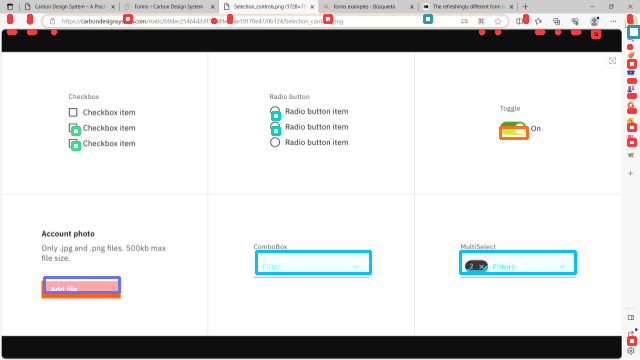

In [5]:
result.export_visuals(export_dir="runs/detect/predict/", hide_labels=True, hide_conf=True)
Image("runs/detect/predict/prediction_visual.png")

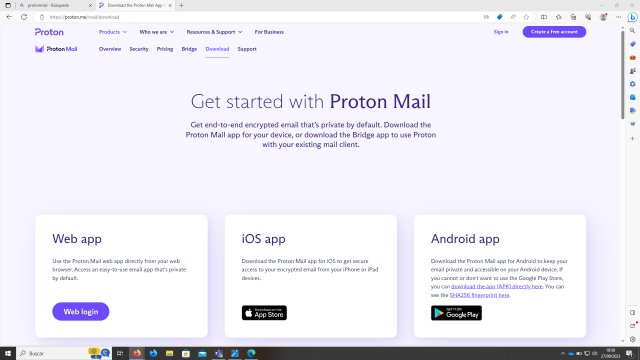

In [74]:

Image("../Augmented_Datasets/ElementLevel/Captura de pantalla (38)_1.png")

Performing prediction on 16 number of slices.


11/17/2023 12:24:26 - INFO - sahi.models.yolov8 -   shift_amount: [0, 0], full_shape: [640, 640]
11/17/2023 12:24:27 - INFO - sahi.models.yolov8 -   shift_amount: [168, 0], full_shape: [640, 640]
11/17/2023 12:24:27 - INFO - sahi.models.yolov8 -   shift_amount: [336, 0], full_shape: [640, 640]
11/17/2023 12:24:27 - INFO - sahi.models.yolov8 -   shift_amount: [400, 0], full_shape: [640, 640]
11/17/2023 12:24:28 - INFO - sahi.models.yolov8 -   shift_amount: [0, 168], full_shape: [640, 640]
11/17/2023 12:24:28 - INFO - sahi.models.yolov8 -   shift_amount: [168, 168], full_shape: [640, 640]
11/17/2023 12:24:29 - INFO - sahi.models.yolov8 -   shift_amount: [336, 168], full_shape: [640, 640]
11/17/2023 12:24:29 - INFO - sahi.models.yolov8 -   shift_amount: [400, 168], full_shape: [640, 640]
11/17/2023 12:24:29 - INFO - sahi.models.yolov8 -   shift_amount: [0, 336], full_shape: [640, 640]
11/17/2023 12:24:30 - INFO - sahi.models.yolov8 -   shift_amount: [168, 336], full_shape: [640, 640]
11/1

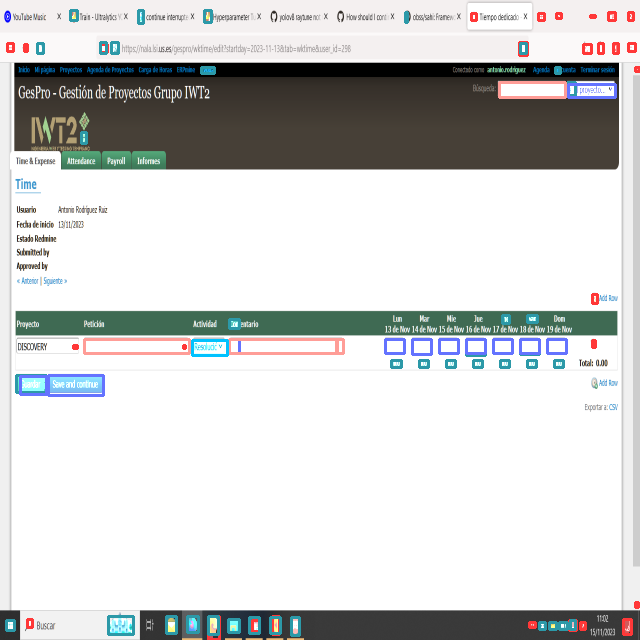

In [8]:
from ultralytics import YOLO
img = cv2.imread("../Captura de pantalla (87).png")
# resize img to 640x360
img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
cv2.imwrite(img, "../640x360.png")
result = get_sliced_prediction(
    img,
    detection_model,
    slice_height=240,
    slice_width=240,
    overlap_height_ratio=0.3,
    overlap_width_ratio=0.3,
    perform_standard_pred=True,
)
result.export_visuals(export_dir="runs/detect/predict/", hide_labels=True, hide_conf=True)
Image("runs/detect/predict/prediction_visual.png")

In [8]:
object_prediction_list = result.object_prediction_list
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [536.0, 30.0, 7.0, 3.0],
  'score': 0.9444300532341003,
  'category_id': 0,
  'category_name': 'WebIcon',
  'segmentation': [[537,
    30,
    536,
    31,
    536,
    32,
    537,
    33,
    542,
    33,
    543,
    32,
    543,
    31,
    542,
    30]],
  'iscrowd': 0,
  'area': 19},
 {'image_id': None,
  'bbox': [628.0, 337.0, 7.0, 7.0],
  'score': 0.9421236515045166,
  'category_id': 0,
  'category_name': 'WebIcon',
  'segmentation': [[629,
    337,
    628,
    338,
    628,
    343,
    629,
    344,
    630,
    344,
    631,
    343,
    631,
    342,
    633,
    340,
    634,
    340,
    635,
    339,
    635,
    338,
    634,
    337]],
  'iscrowd': 0,
  'area': 32},
 {'image_id': None,
  'bbox': [496.0, 30.0, 3.0, 3.0],
  'score': 0.937554657459259,
  'category_id': 0,
  'category_name': 'WebIcon',
  'segmentation': [[497,
    30,
    496,
    31,
    496,
    32,
    497,
    33,
    498,
    33,
    499,
    32,
    499,
    31,
    498

In [14]:
from ultralytics import YOLO
model = YOLO("../Models/trained/Yolov8n-seg - Elements/best.pt")
results = model("../Captura de pantalla (87).png")
print(results[0].tojson())


image 1/1 d:\Code\Screen2SOM-Training\Training\..\Captura de pantalla (87).png: 384x640 22 WebIcons, 13 Icons, 2 BtnSqs, 111.0ms
Speed: 15.0ms preprocess, 111.0ms inference, 142.8ms postprocess per image at shape (1, 3, 384, 640)


[
  {
    "name": "Icon",
    "class": 1,
    "confidence": 0.8979768753051758,
    "box": {
      "x1": 684.6908569335938,
      "y1": 1040.3271484375,
      "x2": 715.6142578125,
      "y2": 1066.974365234375
    },
    "segments": {
      "x": [
        699.0,
        696.0,
        696.0,
        699.0,
        714.0,
        717.0,
        717.0,
        714.0
      ],
      "y": [
        1044.0,
        1047.0,
        1062.0,
        1065.0,
        1065.0,
        1062.0,
        1047.0,
        1044.0
      ]
    }
  },
  {
    "name": "Icon",
    "class": 1,
    "confidence": 0.8923619389533997,
    "box": {
      "x1": 622.92333984375,
      "y1": 1041.10107421875,
      "x2": 653.7176513671875,
      "y2": 1070.714599609375
    },
    "segments": {
      "x": [
        627.0,
        624.0,
        624.0,
        627.0,
        642.0,
        645.0,
        645.0,
        651.0,
        654.0,
        657.0,
        657.0,
        654.0
      ],
      "y": [
        1044.0

In [25]:
from sahi.utils.cv import read_image_as_pil
import numpy as np
image_pil = read_image_as_pil("../Datasets/Dataset_640x360/Captura de pantalla (44)_2.png")
detection_model.perform_inference(np.ascontiguousarray(image_pil))

In [29]:
detection_model.convert_original_predictions(
    shift_amount=[0.0,0.0],
    full_shape=None,
)
object_prediction_list = detection_model.object_prediction_list

11/17/2023 11:42:47 - WARNING - sahi.models.yolov8 -   ignoring invalid prediction with bbox: [608.9059, 4.0619354, 613.8021, 8.7736435] and error: Invalid boolean mask.
11/17/2023 11:42:47 - WARNING - sahi.models.yolov8 -   ignoring invalid prediction with bbox: [210.79703, 4.978222, 214.43045, 8.885952] and error: Invalid boolean mask.


In [30]:
from sahi.prediction import PredictionResult
results = PredictionResult(
    image=image_pil, object_prediction_list=object_prediction_list
)

In [21]:
for r in results:
    print(r.boxes.data[r.boxes.data[:, 4] >= 0.4])

tensor([[6.8469e+02, 1.0403e+03, 7.1561e+02, 1.0670e+03, 8.9798e-01, 1.0000e+00],
        [6.2292e+02, 1.0411e+03, 6.5372e+02, 1.0707e+03, 8.9236e-01, 1.0000e+00],
        [5.6084e+02, 1.0392e+03, 5.9437e+02, 1.0691e+03, 8.9129e-01, 1.0000e+00],
        [8.0970e+02, 1.0417e+03, 8.3955e+02, 1.0681e+03, 8.8820e-01, 1.0000e+00],
        [8.7079e+02, 1.0408e+03, 9.0132e+02, 1.0697e+03, 8.6628e-01, 1.0000e+00],
        [2.1176e+02, 1.5566e+01, 2.3151e+02, 3.8507e+01, 8.5710e-01, 1.0000e+00],
        [1.6805e+03, 1.0485e+03, 1.6978e+03, 1.0649e+03, 8.5248e-01, 1.0000e+00],
        [4.1112e+02, 1.7433e+01, 4.3095e+02, 3.7702e+01, 8.4908e-01, 1.0000e+00],
        [6.1067e+02, 1.7921e+01, 6.3258e+02, 3.7013e+01, 8.1175e-01, 1.0000e+00],
        [7.4687e+02, 1.0421e+03, 7.7967e+02, 1.0717e+03, 7.9896e-01, 1.0000e+00],
        [1.8333e+03, 1.8768e+01, 1.8466e+03, 3.0817e+01, 7.9820e-01, 0.0000e+00],
        [1.8716e+03, 1.0407e+03, 1.8972e+03, 1.0696e+03, 7.9678e-01, 0.0000e+00],
        [4.9897e